In [1]:
import kagglehub
import os
import shutil
import glob
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

In [3]:
data_folder = "./datasets/Hand-Detection-Data-v2"

base_path = Path('datasets/Hand-Detection-Data-v2/1')
train_img_dir = base_path / 'train/images'
train_lbl_dir = base_path / 'train/labels/YOLO'

val_img_dir = base_path / 'valid/images'
val_lbl_dir = base_path / 'valid/labels/YOLO'

In [4]:
# Download latest version
path = kagglehub.dataset_download("nomihsa965/hand-detection-dataset-vocyolo-format")

os.makedirs(data_folder, exist_ok=True)

# Move the downloaded files to the specified relative path
shutil.move(path, os.path.join(data_folder, os.path.basename(path)))

print("Path to dataset files:", os.path.join(data_folder, os.path.basename(path)))

100%|██████████| 73.7M/73.7M [00:14<00:00, 5.29MB/s]

Extracting model files...


Path to dataset files: ./datasets/Hand-Detection-Data-v2\1


In [3]:
# Create validation directories if they don't exist
val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

# Parameters
VAL_RATIO = 0.15  # use 15% for validation

# Get all training images
image_files = list(train_img_dir.glob('*.jpg')) + list(train_img_dir.glob('*.png'))
random.shuffle(image_files)

# Split out a validation set
val_count = int(len(image_files) * VAL_RATIO)
val_images = image_files[:val_count]

# Move val files to new directories
for img_path in val_images:
    label_path = train_lbl_dir / (img_path.stem + '.txt')
    
    if label_path.exists():
        shutil.move(str(img_path), val_img_dir / img_path.name)
        shutil.move(str(label_path), val_lbl_dir / label_path.name)
    else:
        print(f"⚠️ Label file missing for {img_path.name}, skipping.")

In [6]:
train_dir = os.path.abspath('./datasets/Hand-Detection-Data-v2/1/train/images')
# valid_dir = os.path.abspath('./datasets/Hand-Detection-Data/1/valid/images')
test_dir = os.path.abspath('./datasets/Hand-Detection-Data-v2/1/test/images')

for d in [train_dir, test_dir]:
    print(f"{d} exists: {os.path.exists(d)}")

# Optional: Check how many image files are in each directory
train_images = glob.glob(os.path.join(train_dir, '*.jpg')) + \
               glob.glob(os.path.join(train_dir, '*.png'))
# val_images = glob.glob(os.path.join(val_img_dir, '*.jpg')) + \
#              glob.glob(os.path.join(val_img_dir, '*.png'))
test_images = glob.glob(os.path.join(test_dir, '*.jpg')) + \
              glob.glob(os.path.join(test_dir, '*.png'))

print(f"Number of training images: {len(train_images)}")
# print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")


c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images exists: True
c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\test\images exists: True
Number of training images: 1551
Number of test images: 510


Image path: c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_10.jpg
Label path: c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\labels\YOLO\Poselet_10.txt
✅ Label file contents:
0 0.2353515625 0.7317708333333334 0.0712890625 0.09375
0 0.3818359375 0.87890625 0.0712890625 0.11979166666666667
0 0.4970703125 0.8346354166666666 0.09765625 0.12630208333333334
0 0.4970703125 0.8346354166666666 0.09765625 0.12630208333333334



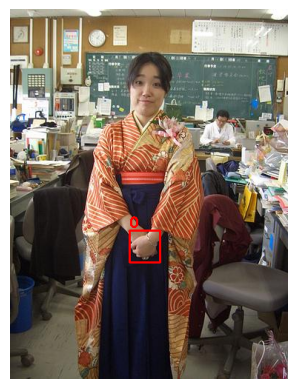

In [7]:
sample_img_path = train_images[0]  # e.g., .../train/images/VOC2007_175.jpg

# Extract just the filename without extension
basename = os.path.basename(sample_img_path).rsplit('.', 1)[0]  # VOC2007_175
label_path = os.path.join(
    os.path.dirname(sample_img_path).replace('images', 'labels\\YOLO'),
    f"{basename}.txt"
)

print("Image path:", sample_img_path)
print("Label path:", label_path)

# Check if file exists
if not os.path.exists(label_path):
    print("❌ Label file not found!")
else:
    with open(label_path, 'r') as f:
        print("✅ Label file contents:")
        print(f.read())

def show_image_with_bboxes(img_path):
    import os

    # Get base name like "VOC2007_175"
    basename = os.path.basename(img_path).rsplit('.', 1)[0]

    # Get path to YOLO label file
    label_path = os.path.join(
        os.path.dirname(img_path).replace(f"{os.sep}images", f"{os.sep}labels{os.sep}YOLO"),
        f"{basename}.txt"
    )

    # Read and display image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Check for label file
    if not os.path.exists(label_path):
        print(f"❌ No label file found at {label_path}")
        plt.imshow(img)
        plt.title("No label file found")
        plt.axis('off')
        plt.show()
        return

    # Draw bounding boxes
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            cls_idx, x_c, y_c, bbox_w, bbox_h = map(float, line.strip().split())
            x_c *= w
            y_c *= h
            bbox_w *= w
            bbox_h *= h
            x1 = int(x_c - bbox_w / 2)
            y1 = int(y_c - bbox_h / 2)
            x2 = int(x_c + bbox_w / 2)
            y2 = int(y_c + bbox_h / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, str(int(cls_idx)), (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
# Display random training image with bounding box
random_img = random.choice(train_images)
show_image_with_bboxes(random_img)


In [ ]:
# Move the labels for the YOLO out of the nested directory

base = Path("./datasets/Hand-Detection-Data-v2/1")

for split in ['train', 'test']:
    yolodir = base / split / 'labels' / 'YOLO'
    targetdir = base / split / 'labels'

    # Move all .txt files up one level
    for file in yolodir.glob("*.txt"):
        shutil.move(str(file), targetdir / file.name)
    
    # Optional: remove empty YOLO/ folder
    yolodir.rmdir()

In [12]:
#Step-by-Step Code to Create the Normalized Hand-Version
def create_hand_only_labels(src_root, dst_root):
    """
    Copies YOLO images and labels from `src_root` to `dst_root`,
    and replaces all class IDs with 0 for hand detection.
    """

    src_root = Path(src_root)
    dst_root = Path(dst_root)
    
    for split in ['train', 'valid', 'test']:
        src_img_dir = src_root / split / 'images'
        src_lbl_dir = src_root / split / 'labels'

        dst_img_dir = dst_root / split / 'images'
        dst_lbl_dir = dst_root / split / 'labels'

        dst_img_dir.mkdir(parents=True, exist_ok=True)
        dst_lbl_dir.mkdir(parents=True, exist_ok=True)

        for img_file in src_img_dir.glob("*.jpg"):
            shutil.copy(img_file, dst_img_dir / img_file.name)

        for label_file in src_lbl_dir.glob("*.txt"):
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    parts[0] = '0'  # normalize class label to 0 (for "hand")
                    new_lines.append(" ".join(parts))

            with open(dst_lbl_dir / label_file.name, 'w') as f:
                f.write("\n".join(new_lines))

        print(f"✅ Processed {split} set: {len(list(dst_img_dir.glob('*.jpg')))} images")

# Run conversion
create_hand_only_labels(
    src_root="datasets/Letter-Classification-Data",
    dst_root="datasets/Letter-HandDetection-Version"
)

KeyboardInterrupt: 

In [12]:
# Merge the Normalized Version Into Your Hand Detection Dataset
def merge_to_hand_dataset(letter_set, hand_set):
    letter_img_dir = Path(f"datasets/Letter-HandDetection-Version/{letter_set}/images")
    letter_lbl_dir = Path(f"datasets/Letter-HandDetection-Version/{letter_set}/labels")
    
    hand_img_dir = Path(f"datasets/Hand-Detection-Data/1/{hand_set}/images")
    hand_lbl_dir = Path(f"datasets/Hand-Detection-Data/1/{hand_set}/labels")

    hand_img_dir.mkdir(parents=True, exist_ok=True)
    hand_lbl_dir.mkdir(parents=True, exist_ok=True)

    for img_file in letter_img_dir.glob("*.jpg"):
        shutil.copy(img_file, hand_img_dir / img_file.name)

    for lbl_file in letter_lbl_dir.glob("*.txt"):
        shutil.copy(lbl_file, hand_lbl_dir / lbl_file.name)

# Merge each set
merge_to_hand_dataset("train", "train")
merge_to_hand_dataset("valid", "valid")
merge_to_hand_dataset("test", "test")

In [17]:
# Load a pretrained YOLOv8 model (use yolov8n.pt for lightweight testing)
yaml_path = Path('datasets/Hand-Detection-Data-v2/1/data.yaml').resolve()

print("Using data.yaml path:", yaml_path)

model = YOLO('yolov8s.pt')


Using data.yaml path: C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\data.yaml


In [14]:
metrics = model.val()
#print(metrics)

Ultralytics 8.3.96  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\coco\labels\val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:16<00:00, 312.46it/s]


val: New cache created: C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\coco\labels\val2017.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


                   all       5000      36335      0.683      0.563      0.613      0.448
                person       2693      10777       0.79      0.715      0.794      0.574
               bicycle        149        314       0.71      0.449      0.568      0.343
                   car        535       1918      0.719      0.596      0.659      0.443
            motorcycle        159        367      0.772      0.649      0.733      0.482
              airplane         97        143      0.852      0.853      0.917      0.742
                   bus        189        283      0.813      0.753      0.818      0.701
                 train        157        190      0.835      0.847      0.891      0.691
                 truck        250        414      0.613      0.449      0.543      0.388
                  boat        121        424      0.639      0.408      0.476      0.267
         traffic light        191        634      0.731       0.45      0.527      0.277
          fire hydran

In [18]:
yaml_path = Path('datasets/Hand-Detection-Data-v2/1/data.yaml').resolve()

model.train(
    data=str(yaml_path),  # <--- pass as string
    epochs=50,
    imgsz=640,
    batch=8,
    name='hand-detect-small-v16',
    project='runs/detect'
)

Ultralytics 8.3.96  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=hand-detect-small-v163, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\labels... 1550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1550/1550 [00:04<00:00, 334.82it/s]

train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_10.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_180.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_247.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_268.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_282.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\images\Poselet_290.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\dataset

train: New cache created: C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\train\labels.cache


val: Scanning C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\val\labels... 0 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 649.27it/s]

val: WARNING  No labels found in C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\val\labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\val\labels.cache
WARNING  No labels found in C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data-v2\1\val\labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs\detect\hand-detect-small-v163\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\hand-detect-small-v163
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.63G      1.822      2.108      1.643         19        640: 100%|██████████| 194/194 [00:39<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.67G      1.797      1.756      1.614         21        640: 100%|██████████| 194/194 [00:32<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.71it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.71G      1.804      1.772      1.621         19        640: 100%|██████████| 194/194 [00:32<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.74G      1.769      1.711      1.617         15        640: 100%|██████████| 194/194 [00:31<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.78G      1.761      1.618      1.592         13        640: 100%|██████████| 194/194 [00:31<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.71it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.81G      1.728      1.576      1.578         20        640: 100%|██████████| 194/194 [00:33<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.85G      1.683      1.493      1.561         28        640: 100%|██████████| 194/194 [00:31<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.89G      1.688      1.454      1.546         16        640: 100%|██████████| 194/194 [00:32<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.49it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.92G       1.65      1.384      1.531         28        640: 100%|██████████| 194/194 [00:32<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.96G      1.603      1.299      1.492         17        640: 100%|██████████| 194/194 [00:32<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         3G      1.599      1.326      1.485         29        640: 100%|██████████| 194/194 [00:45<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.03G       1.58      1.236       1.48         22        640: 100%|██████████| 194/194 [00:41<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.07G      1.566      1.222      1.468         28        640: 100%|██████████| 194/194 [00:42<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.11G      1.534      1.178      1.445         19        640: 100%|██████████| 194/194 [00:49<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.14G      1.541      1.166      1.453         18        640: 100%|██████████| 194/194 [00:55<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.18G        1.5      1.131      1.429         19        640: 100%|██████████| 194/194 [00:47<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.21G      1.496      1.117      1.424         13        640: 100%|██████████| 194/194 [00:54<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all          1          0          0          0          0          0



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


WARNING  no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.25G      1.494      1.109      1.426         17        640: 100%|██████████| 194/194 [00:55<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.29G      1.484      1.055       1.42         16        640: 100%|██████████| 194/194 [00:52<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.32G      1.465      1.038       1.41         14        640: 100%|██████████| 194/194 [00:51<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.36G      1.446      1.017       1.39         22        640: 100%|██████████| 194/194 [00:48<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.41G      1.411     0.9841      1.379         23        640: 100%|██████████| 194/194 [00:51<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.48G      1.442     0.9956      1.377         20        640: 100%|██████████| 194/194 [00:50<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.56G      1.393     0.9384      1.368         18        640: 100%|██████████| 194/194 [00:52<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.61G      1.384     0.9359      1.341         20        640: 100%|██████████| 194/194 [00:40<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.68G       1.37     0.8993      1.344         12        640: 100%|██████████| 194/194 [00:33<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.75G      1.346     0.8909      1.324         21        640: 100%|██████████| 194/194 [00:36<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.81G      1.342     0.8643      1.322         25        640: 100%|██████████| 194/194 [00:41<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.88G      1.331     0.8678      1.323         20        640: 100%|██████████| 194/194 [00:32<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.95G      1.298     0.8428      1.299          9        640: 100%|██████████| 194/194 [00:32<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         4G      1.299     0.8344      1.291         18        640: 100%|██████████| 194/194 [00:36<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.07G      1.281     0.8083      1.286         13        640: 100%|██████████| 194/194 [00:39<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.13G      1.288     0.8118      1.292         11        640: 100%|██████████| 194/194 [00:40<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       4.2G      1.248     0.7757      1.271         19        640: 100%|██████████| 194/194 [01:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all          1          0          0          0          0          0



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


WARNING  no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.27G      1.242     0.7668      1.258         25        640: 100%|██████████| 194/194 [00:52<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



c:\Users\cjmij\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\cjmij\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.34G      1.241     0.7271      1.254         25        640:   9%|▉         | 17/194 [00:03<00:34,  5.07it/s]


KeyboardInterrupt: 

In [8]:
results = model.predict(
    source='datasets/Hand-Detection-Data/1/test/images',
    conf=0.25,
    save=True  # saves annotated predictions to disk
)


image 1/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 hand, 90.2ms
image 2/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 hand, 16.9ms
image 3/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg: 640x640 1 hand, 12.7ms
image 4/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B19_jpg.rf.69527cc1f34d694cc04e55db80ed9b1a.jpg: 640x640 1 hand, 10.9ms
image 5/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\C17_jpg.rf.ceb81f8ae3c3673bd060ebe71848eca8.jpg: 640x640 1 hand, 12.2ms
image 6/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\C19_jpg.rf.577ce02a22

In [17]:
from PIL import Image

# Path to YOLO predictions folder
pred_dir = Path('runs/detect/hand-detect-medium-v162')

# Get list of prediction images (YOLO saves them in the root of the folder)
img_files = list(pred_dir.glob('*.jpg')) + list(pred_dir.glob('*.png'))

# Display the first prediction
if img_files:
    img = Image.open(img_files[150])
    img.show()
else:
    print("❌ No predicted images found in", pred_dir)

In [20]:
# Source: where YOLO saved the trained model
source_model_path = 'runs/detect/hand-detect-medium-v16/weights/best.pt'

# Destination: your streamlit app's model folder
dest_model_path = 'yolov8_medium_model/best_medium.pt'

# Copy
shutil.copy(source_model_path, dest_model_path)

print("✅ Model copied to yolov8_model/best.pt")

✅ Model copied to yolov8_model/best.pt
